In [1]:
import pickle
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import json
import seaborn as sns
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


from helper import extract_data, create_features, sorted_correlations_with_gold, \
                    remove_correlated_features, create_lr_plot, create_xgb_plot

# Timeseries Forecating Using ARMA model

In this notebook we analyse the gold price timeseries data and use linear forecasting models of ARIMA family to investigate the performance of such models for timeseries forecasting and do comparison with other ML models.

In [2]:
start_date = '2012-07-15'
end_date= '2020-07-22'
n_days_ahead = 3

In [3]:
with open("tickers.json", "r") as f:
    tickers = json.loads(f.read())

## Data Collection

Let's collect the historical gold prices data and store them in our dataframe.

In [4]:
values = extract_data(start_date, end_date, tickers)
values = values[['date','Gold']]
values.tail()

,date,Gold
2924,2020-07-17,1812.1
2925,2020-07-18,1812.1
2926,2020-07-19,1810.3
2927,2020-07-20,1819.3
2928,2020-07-21,1828.4


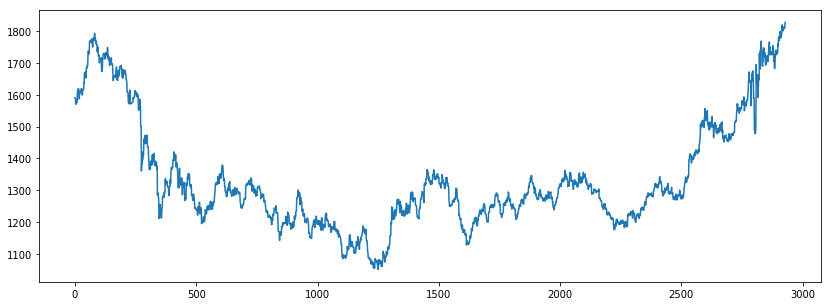

In [5]:
plt.figure(figsize=(14,5))
plt.plot(values['Gold'])

## Checking Seasonality

Seasonality is an important factor in timeseries that can affect performance of models. Before using linear models we should ensure that the data is stationary and does not have any seasonality effect. In case any of these patterns exist, we should remove these effects using techniques such as differencing. 

After decomposing the data, we do not see any seasonality effect.

<Figure size 864x432 with 0 Axes>

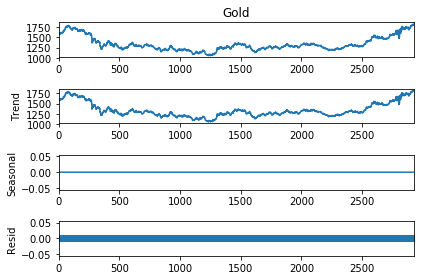

In [6]:
plt.figure(figsize=(12,6))
a = seasonal_decompose(values['Gold'], period=1).plot()

Next step is to check stationarity of the timeseries. In non-stationary data, the statistical properties of the data changes over time. Dicky-Fuller is a standard statistical test for checking stationarity of the data. In this test the null hypothesis is that the data is not stationary. If p-value is small enough we can reject the null hypothesis and confirm that the data is stationary.

## Checking Stationarity

For absolute values of gold prices data, the p-value is not low enough to reject, so we know that the data is non-stationary and we need to make it stationary before training the model.

In [7]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    stationary = True
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        if result[0]>=value:
            print("variable is not stationary")
            stationary=False
    if stationary:
        print("variable is stationary")

In [8]:
check_stationarity(values['Gold'])

ADF Statistic: -0.549587
p-value: 0.881971
Critical Values:
	1%: -3.433
variable is not stationary
	5%: -2.863
variable is not stationary
	10%: -2.567
variable is not stationary


In the next step we calculate the percentage change of the gold prices compared to the previous day. Using Dicky-Fuller test we can see that the new series is now stationary.

In [9]:
values['Gold_diff'] = values['Gold'].diff()
#values = values.dropna()
values['Gold_diff'].describe()

count    2928.000000
mean        0.081011
std        11.231579
min      -140.400000
25%        -3.200000
50%         0.000000
75%         3.200000
max       120.400000
Name: Gold_diff, dtype: float64

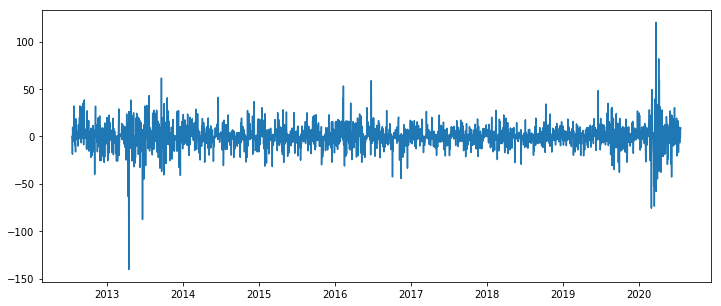

In [10]:
plt.figure(figsize=(12,5))
plt.plot(values['date'], values['Gold_diff'])

In [11]:
check_stationarity(values['Gold_diff'].iloc[1:])

ADF Statistic: -12.249813
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
variable is stationary


## ACF and PACF Plots

An important step before running thr ARIMA model is to plot auto correlation and partial autocorrelation plots to understand what are the most proper lags for AR and MA components. Looking at the ACF and PACF plots of the gold return shows very small correlations in the timeseries, which can't help much on deciding on parameters of the model. However we see that if we apply differencing on the gold price diff data, clear patterns emerge in ACF and PACF plots. In the next step we apply second order differencing.

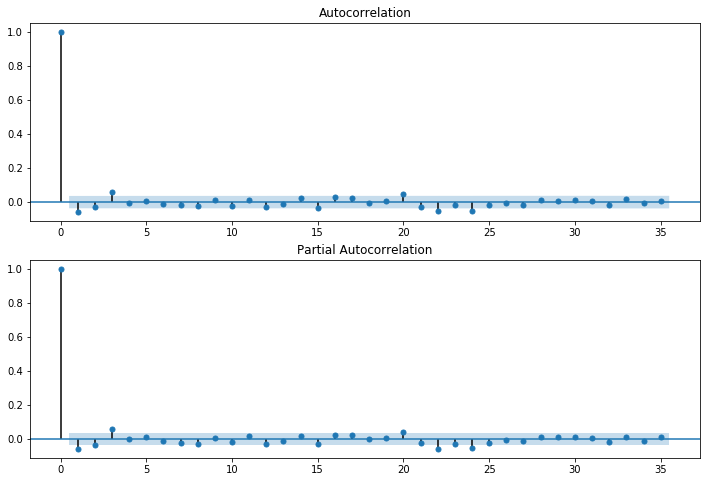

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plot_acf(values['Gold_diff'].iloc[1:], ax=plt.gca())
plt.subplot(212)
plot_pacf(values['Gold_diff'].iloc[1:], ax=plt.gca())
plt.show()

In [24]:
values['Gold_diff_diff'] = values['Gold_diff'].diff()
#values = values.dropna()

In [26]:
check_stationarity(values['Gold_diff_diff'].iloc[2:])

ADF Statistic: -17.371093
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
variable is stationary


After applying second order differencing, we can clearly observe that ACF shows significant correlation on the first lag, while the PACF plot shows geometric decay of the coefficients. This pattern matches the Moving Average (MA) pattern of ARIMA with lag=1. Based on this observation we choose (p=0,d=0,q=1) parameters for ARIMA model.

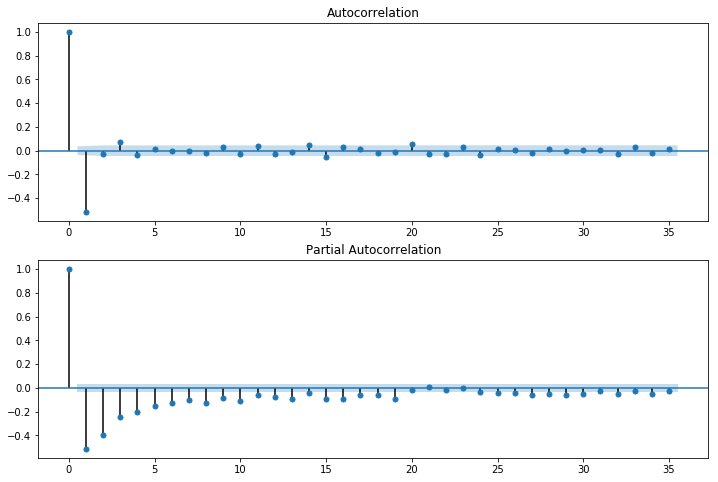

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plot_acf(values['Gold_diff_diff'].iloc[2:], ax=plt.gca())
plt.subplot(212)
plot_pacf(values['Gold_diff_diff'].iloc[2:], ax=plt.gca())
plt.show()

## Model Training

The data is split in 2 parts for training and evaluating the model.

In [30]:
X_train = values[values['date'] < '2018-01-01']['Gold_diff_diff']
X_test = values[values['date'] >= '2018-01-01']['Gold_diff_diff']

In [45]:
data = [x for x in X_train.iloc[2:]]

predictions = list()
for i in range(len(X_test)):
    model = ARIMA(data, order=(0,0,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = X_test.iloc[i]
    data.append(obs)
    print('Prediction=%.3f, Groundtruth=%3.f' % (yhat, obs))

Prediction=-5.204, Groundtruth=  0
Prediction=-5.193, Groundtruth=  7
Prediction=-12.572, Groundtruth= -5
Prediction=-7.655, Groundtruth=  1
Prediction=-8.338, Groundtruth= -2
Prediction=-6.025, Groundtruth= -1
Prediction=-5.114, Groundtruth=  0
Prediction=-5.104, Groundtruth= -2
Prediction=-3.396, Groundtruth= -5
Prediction=1.803, Groundtruth= 13
Prediction=-10.781, Groundtruth= -3
Prediction=-8.264, Groundtruth= 10
Prediction=-17.834, Groundtruth=-13
Prediction=-5.017, Groundtruth=  0
Prediction=-5.007, Groundtruth=  0
Prediction=-4.997, Groundtruth=  2
Prediction=-6.984, Groundtruth=  1
Prediction=-7.569, Groundtruth=-15
Prediction=7.025, Groundtruth= 18
Prediction=-10.862, Groundtruth= -6
Prediction=-4.949, Groundtruth=  0
Prediction=-4.939, Groundtruth= -1
Prediction=-3.931, Groundtruth=  6
Prediction=-9.714, Groundtruth= 15
Prediction=-25.073, Groundtruth=-14
Prediction=-11.344, Groundtruth=-17
Prediction=5.953, Groundtruth= 11
Prediction=-4.842, Groundtruth=  0
Prediction=-4.832

/Users/ali.zonoozi/anaconda3/envs/scotia/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Prediction=-1.547, Groundtruth= 18
Prediction=-20.018, Groundtruth=-23
Prediction=3.088, Groundtruth=  2
Prediction=1.585, Groundtruth=  9
Prediction=-7.005, Groundtruth= -2


/Users/ali.zonoozi/anaconda3/envs/scotia/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/ali.zonoozi/anaconda3/envs/scotia/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/ali.zonoozi/anaconda3/envs/scotia/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/ali.zonoozi/anaconda3/envs/scotia/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Prediction=-4.491, Groundtruth=  0
Prediction=-4.482, Groundtruth= -3
Prediction=-1.481, Groundtruth= 10
Prediction=-10.962, Groundtruth= -8
Prediction=-2.952, Groundtruth= -6
Prediction=3.145, Groundtruth=  2
Prediction=1.043, Groundtruth=  6
Prediction=-4.450, Groundtruth=  0
Prediction=-4.438, Groundtruth=  6
Prediction=-9.924, Groundtruth=-11
Prediction=1.280, Groundtruth= 15
Prediction=-14.000, Groundtruth= -4
Prediction=-10.279, Groundtruth= 17
Prediction=-27.034, Groundtruth=-23
Prediction=-4.313, Groundtruth=  0
Prediction=-4.306, Groundtruth=  5
Prediction=-9.391, Groundtruth=-18
Prediction=8.802, Groundtruth= -4
Prediction=12.782, Groundtruth= 16
Prediction=-2.919, Groundtruth=  1
Prediction=-4.311, Groundtruth=  0
Prediction=-4.301, Groundtruth=  0
Prediction=-4.293, Groundtruth= 19
Prediction=-22.167, Groundtruth=-29
Prediction=6.189, Groundtruth= 12
Prediction=-5.885, Groundtruth=-14
Prediction=8.234, Groundtruth= 19
Prediction=-10.437, Groundtruth= -8
Prediction=-2.761, G

Prediction=4.866, Groundtruth=  5
Prediction=-0.230, Groundtruth=  0
Prediction=-0.225, Groundtruth= -1
Prediction=0.868, Groundtruth= -5
Prediction=5.712, Groundtruth=  8
Prediction=-2.659, Groundtruth= -6
Prediction=3.013, Groundtruth=-13
Prediction=16.057, Groundtruth= 16
Prediction=-0.437, Groundtruth=  0
Prediction=-0.431, Groundtruth= -5
Prediction=4.627, Groundtruth=  3
Prediction=1.613, Groundtruth= 11
Prediction=-9.098, Groundtruth= -4
Prediction=-5.245, Groundtruth=  3
Prediction=-8.262, Groundtruth= -8
Prediction=-0.257, Groundtruth=  0
Prediction=-0.253, Groundtruth=  2
Prediction=-2.526, Groundtruth= -6
Prediction=3.839, Groundtruth= 11
Prediction=-6.990, Groundtruth= -7
Prediction=-0.186, Groundtruth=  0
Prediction=-0.182, Groundtruth=  0
Prediction=-0.178, Groundtruth=  0
Prediction=-0.175, Groundtruth= -6
Prediction=5.374, Groundtruth= -3
Prediction=8.692, Groundtruth= 19
Prediction=-10.405, Groundtruth= -8
Prediction=-2.875, Groundtruth= -7
Prediction=3.691, Groundtrut

Prediction=4.453, Groundtruth=  4
Prediction=-0.044, Groundtruth= -1
Prediction=1.247, Groundtruth=-14
Prediction=15.300, Groundtruth=  4
Prediction=10.899, Groundtruth= 29
Prediction=-17.829, Groundtruth=-19
Prediction=1.162, Groundtruth=  0
Prediction=1.153, Groundtruth= -8
Prediction=8.970, Groundtruth=  8
Prediction=1.062, Groundtruth=  2
Prediction=-1.125, Groundtruth= -4
Prediction=2.950, Groundtruth=  2
Prediction=0.547, Groundtruth= 12
Prediction=-11.442, Groundtruth=-18
Prediction=6.895, Groundtruth= 11
Prediction=-4.460, Groundtruth= -6
Prediction=1.131, Groundtruth=  8
Prediction=-7.000, Groundtruth=-15
Prediction=7.828, Groundtruth=  4
Prediction=3.300, Groundtruth= 14
Prediction=-10.895, Groundtruth= -7
Prediction=-3.558, Groundtruth= -6
Prediction=2.223, Groundtruth=  1
Prediction=1.214, Groundtruth=  1
Prediction=-0.182, Groundtruth= -3
Prediction=2.398, Groundtruth= -4
Prediction=6.340, Groundtruth=  8
Prediction=-1.543, Groundtruth=-12
Prediction=9.966, Groundtruth= 13

Prediction=-6.198, Groundtruth=  2
Prediction=-7.728, Groundtruth= 19
Prediction=-26.395, Groundtruth=-28
Prediction=1.594, Groundtruth= 22
Prediction=-20.719, Groundtruth=-17
Prediction=-3.485, Groundtruth=-31
Prediction=27.075, Groundtruth= 19
Prediction=8.404, Groundtruth= 10
Prediction=-1.580, Groundtruth= -4
Prediction=2.104, Groundtruth=  1
Prediction=1.493, Groundtruth=  0
Prediction=1.483, Groundtruth=-76
Prediction=76.627, Groundtruth=104
Prediction=-27.037, Groundtruth= 22
Prediction=-48.128, Groundtruth=-51
Prediction=2.850, Groundtruth= 26
Prediction=-23.350, Groundtruth=-25
Prediction=1.638, Groundtruth=  0
Prediction=1.627, Groundtruth=  4
Prediction=-2.747, Groundtruth= -1
Prediction=-1.631, Groundtruth=-19
Prediction=16.928, Groundtruth= -3
Prediction=19.368, Groundtruth=-34
Prediction=52.928, Groundtruth= 52
Prediction=0.922, Groundtruth=  0
Prediction=0.917, Groundtruth=-74
Prediction=73.875, Groundtruth= 43
Prediction=30.184, Groundtruth= 70
Prediction=-38.932, Groun

In [50]:
# calculate out of sample error
print("mse : %.2f" %mean_squared_error(X_test, predictions))
print("rmse: %.2f" %np.sqrt(mean_squared_error(X_test, predictions)))
print("r2 score: %.2f" %r2_score(X_test, predictions))

mse : 150.16
rmse: 12.25
r2 score: 0.51


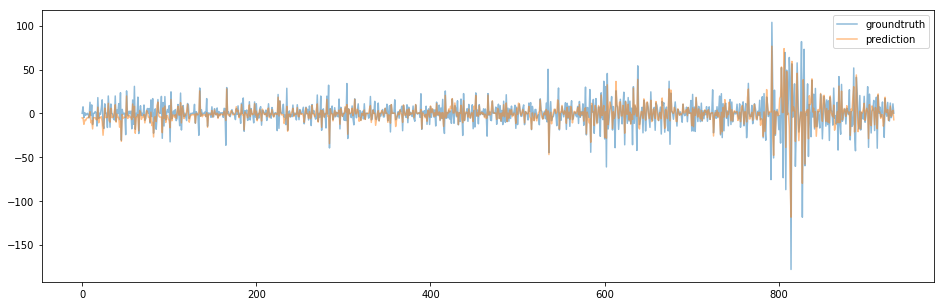

In [53]:
plt.figure(figsize=(16,5))
plt.plot(X_test.values, label="groundtruth", alpha=0.5)
plt.plot(predictions, label="prediction", alpha=0.5)
plt.legend()

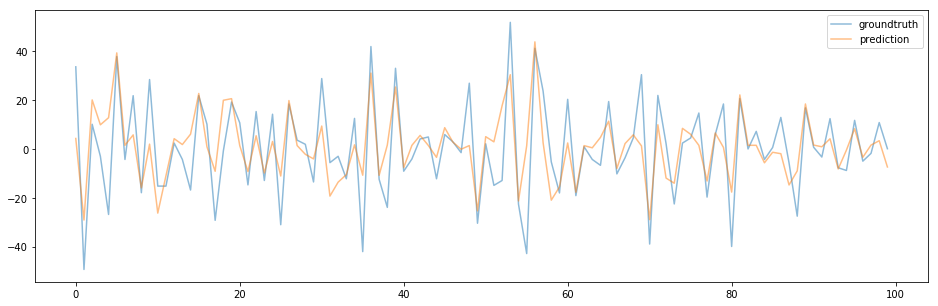

In [54]:
plt.figure(figsize=(16,5))
plt.plot(X_test.values[-100:], label="groundtruth", alpha=0.5)
plt.plot(predictions[-100:], label="prediction", alpha=0.5)
plt.legend()

In [89]:
df_test = values[values['date'] > '2017-12-29'].copy()
df_test['prediction'] = [np.nan, np.nan] + [x[0] for x in predictions]
df_test['Gold_diff_inferred'] = [np.nan , np.nan] + list(df_test['prediction'].iloc[2:].values + df_test['Gold_diff'].iloc[1:-1].values)
df_test['Gold_inferred'] = [np.nan , np.nan] + list(df_test['Gold_diff_inferred'].iloc[2:].values + df_test['Gold'].iloc[1:-1].values)
df_test = df_test.iloc[2:]
df_test.tail(10)


,date,Gold,Gold_diff,Gold_diff_diff,prediction,Gold_diff_inferred,Gold_inferred
2919,2020-07-12,1804.5,0.7,0.7,1.595166,1.595166,1805.395166
2920,2020-07-13,1801.9,-2.6,-3.3,0.891426,1.591426,1806.091426
2921,2020-07-14,1811.7,9.8,12.4,4.164929,1.564929,1803.464929
2922,2020-07-15,1813.8,2.1,-7.7,-8.175809,1.624191,1813.324191
2923,2020-07-16,1807.1,-6.7,-8.8,-0.470080,1.629920,1815.429920
2924,2020-07-17,1812.1,5.0,11.7,8.274893,1.574893,1808.674893
2925,2020-07-18,1812.1,0.0,-5.0,-3.399040,1.600960,1813.700960
2926,2020-07-19,1810.3,-1.8,-1.8,1.592347,1.592347,1813.692347
2927,2020-07-20,1819.3,9.0,10.8,3.371372,1.571372,1811.871372
2928,2020-07-21,1828.4,9.1,0.1,-7.374958,1.625042,1820.925042


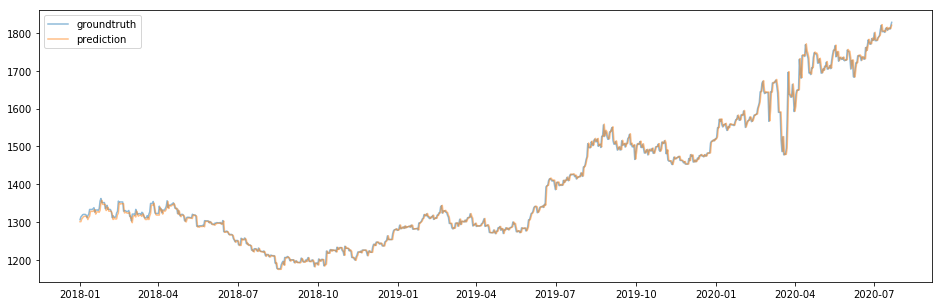

In [91]:
plt.figure(figsize=(16,5))
plt.plot(df_test['date'], df_test['Gold'], label="groundtruth", alpha=0.5)
plt.plot(df_test['date'], df_test['Gold_inferred'], label="prediction", alpha=0.5)
plt.legend()

In [99]:
print("MSE :%.2f" %mean_squared_error(df_test['Gold'], df_test['Gold_inferred']))
print("RMSE : %.2f" %np.sqrt(mean_squared_error(df_test['Gold'], df_test['Gold_inferred'])))

MSE :150.16
RMSE : 12.25


# Inference

In [101]:
model = ARIMA(values['Gold_diff_diff'].iloc[2:].values,order=(0, 0, 1))
results = model.fit()

In [102]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 2927
Model:                     ARMA(0, 1)   Log Likelihood              -11234.575
Method:                       css-mle   S.D. of innovations             11.223
Date:                Wed, 22 Jul 2020   AIC                          22475.150
Time:                        03:41:06   BIC                          22493.096
Sample:                             0   HQIC                         22481.613
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.131      0.033    4.21e-05       0.001
ma.L1.y       -1.0000      0.001  -1077.038      0.000      -1.002      -0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [103]:
vals = results.forecast(steps=3)[0]
vals

array([-8.25588013e+00,  5.22996436e-04,  5.22996436e-04])

In [119]:
df_test = pd.DataFrame({'date':pd.date_range(start='2020-07-01', end='2020-07-24')})
df_test  = pd.merge(left=df_test, right=values[['date','Gold', 'Gold_diff']], on='date',how='left')
df_test['prediction'] = (len(df_test)-3)*[np.nan ] + list(vals)
df_test

,date,Gold,Gold_diff,prediction
0,2020-07-01,1800.5,19.3,NaN
1,2020-07-02,1779.9,-20.6,NaN
2,2020-07-03,1779.9,0.0,NaN
3,2020-07-04,1779.9,0.0,NaN
4,2020-07-05,1787.1,7.2,NaN
5,2020-07-06,1790.0,2.9,NaN
6,2020-07-07,1793.5,3.5,NaN
7,2020-07-08,1809.9,16.4,NaN
8,2020-07-09,1820.6,10.7,NaN
9,2020-07-10,1803.8,-16.8,NaN


In [125]:
for i in range(3,0,-1):
    df_test['Gold_diff'].iloc[-i] = df_test['prediction'].iloc[-i] + df_test['Gold_diff'].iloc[-i-1]
    df_test['Gold'].iloc[-i] = df_test['Gold_diff'].iloc[-i] + df_test['Gold'].iloc[-i-1]
df_test

,date,Gold,Gold_diff,prediction
0,2020-07-01,1800.500000,19.300000,NaN
1,2020-07-02,1779.900000,-20.600000,NaN
2,2020-07-03,1779.900000,0.000000,NaN
3,2020-07-04,1779.900000,0.000000,NaN
4,2020-07-05,1787.100000,7.200000,NaN
5,2020-07-06,1790.000000,2.900000,NaN
6,2020-07-07,1793.500000,3.500000,NaN
7,2020-07-08,1809.900000,16.400000,NaN
8,2020-07-09,1820.600000,10.700000,NaN
9,2020-07-10,1803.800000,-16.800000,NaN


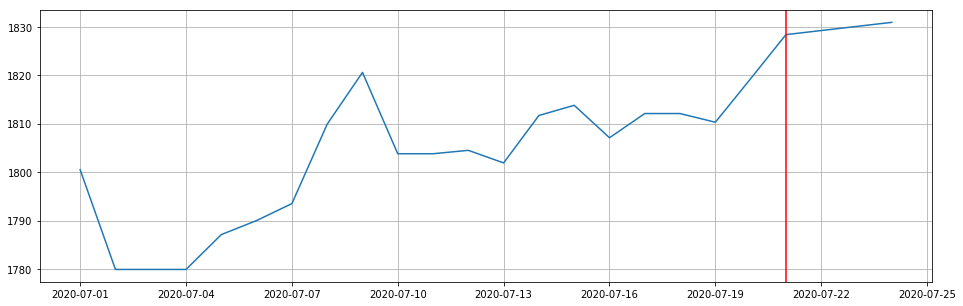

In [134]:
plt.figure(figsize=(16,5))
plt.plot(df_test['date'],df_test['Gold'])
plt.axvline(x='2020-07-21', c='r')
plt.grid()

## Price Forecast on July 24th

In [138]:
df_test[df_test['date']=='2020-07-24']['Gold']

23    1830.933929
Name: Gold, dtype: float64